In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import shutil
import zipfile
import glob
import os
import time

In [2]:
train_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/train')
test_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/test')

print(f'the number of train set : {len(os.listdir(train_dir))}')
print(f'the number of test set : {len(os.listdir(test_dir))}')


normal_files = [f'Normal-{i}.png' for i in range(1,3500)]
tuberculosis_files = [f'Tuberculosis-{i}.png' for i in range(1,700)]


the number of train set : 3360
the number of test set : 840


In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'Normal' in files[0]:
            self.label = 0

        else:
            self.label = 1
        
    def __len__(self):
        return len(self.files)

        
        
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]


In [6]:
from PIL import Image, ImageOps, ImageFilter

class SmothImage(object):

    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)

class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 
            
            
            
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Grayscale(num_output_channels=1),
    #ContrastBrightness(1.2,25),
    #HistEqualization(),
    #SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.4990189, 0.49874797, 0.4984631], [0.21823819, 0.24591278, 0.22876337]),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=1),
    #ContrastBrightness(1.2,25),
    #HistEqualization(),
    #SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5066209, 0.50000274, 0.49914467], [0.20135736, 0.22966754, 0.188137]),
])

'''
0.4990189 0.49874797 0.4984631
0.21823819 0.24591278 0.22876337
0.5066209 0.50000274 0.49914467
0.20135736 0.22966754 0.188137

'''


'\n0.4990189 0.49874797 0.4984631\n0.21823819 0.24591278 0.22876337\n0.5066209 0.50000274 0.49914467\n0.20135736 0.22966754 0.188137\n\n'

In [7]:

train_normal_dataset = CustomDataset(normal_files[:2800], train_dir, transform=train_transform)
train_tuberculosis_dataset = CustomDataset(tuberculosis_files[:560], train_dir, transform=train_transform)
test_normal_dataset = CustomDataset(normal_files[2800:], test_dir, transform=test_transform)
test_tuberculosis_dataset = CustomDataset(tuberculosis_files[560:], test_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_normal_dataset, train_tuberculosis_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_normal_dataset, test_tuberculosis_dataset])



In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

train_norm_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3360, shuffle=True)
test_norm_loader = torch.utils.data.DataLoader(test_dataset, batch_size=840, shuffle=True)


'''
#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])
print(meanR, meanG, meanB)
print(stdR, stdG, stdB)
'''




'\n#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\n\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n'

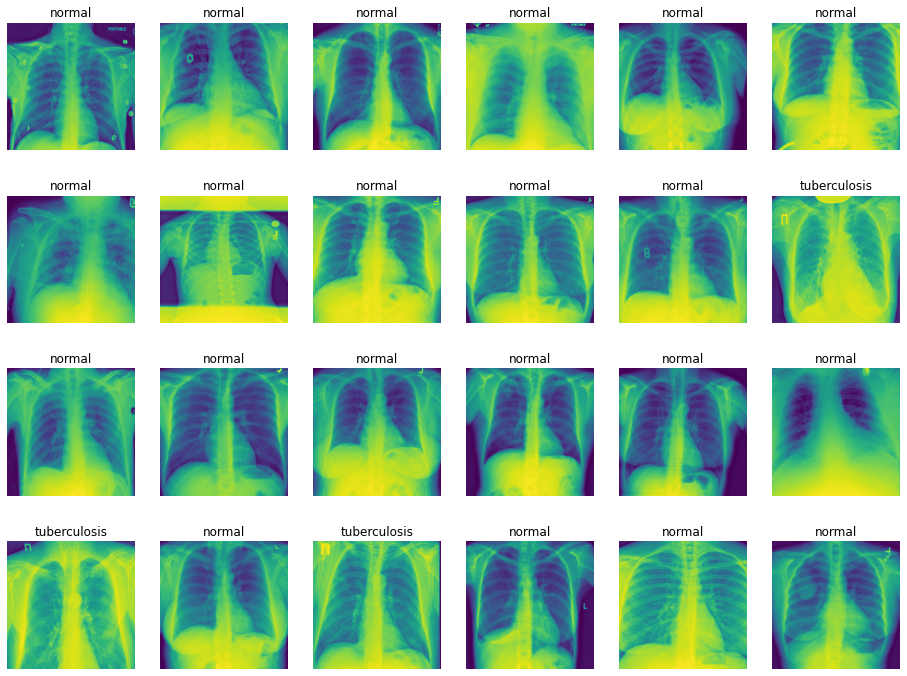

In [9]:
samples, labels = iter(train_loader).next()
classes = {0:'normal', 1:'tuberculosis'}
fig = plt.figure(figsize=(16,24))


for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)



In [161]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [163]:
model = torchvision.models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
nn.Dropout(0.5),
nn.Linear(num_ftrs, 1024),
nn.Dropout(0.2),
nn.Linear(1024, 512),
nn.Dropout(0.1),
nn.Linear(512, 1),
nn.Sigmoid()
)


In [165]:
!pip install torchsummary
from torchsummary import summary

model.cuda()
summary(model, input_size=(3,224,224))


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          

In [166]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
            
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
            
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()



40.682sec : [Epoch 1/10] -> train loss: 0.2811, train acc: 86.339% / valid loss: 0.1572, valid acc: 93.079%
40.146sec : [Epoch 2/10] -> train loss: 0.0730, train acc: 98.452% / valid loss: 0.0362, valid acc: 99.523%
39.960sec : [Epoch 3/10] -> train loss: 0.0289, train acc: 99.315% / valid loss: 0.0295, valid acc: 99.045%
40.345sec : [Epoch 4/10] -> train loss: 0.0180, train acc: 99.524% / valid loss: 0.0103, valid acc: 99.881%
40.442sec : [Epoch 5/10] -> train loss: 0.0098, train acc: 99.702% / valid loss: 0.0100, valid acc: 99.761%
40.561sec : [Epoch 6/10] -> train loss: 0.0079, train acc: 99.792% / valid loss: 0.0262, valid acc: 98.807%
40.580sec : [Epoch 7/10] -> train loss: 0.0083, train acc: 99.762% / valid loss: 0.0137, valid acc: 99.761%
40.636sec : [Epoch 8/10] -> train loss: 0.0031, train acc: 99.940% / valid loss: 0.0106, valid acc: 99.523%
40.622sec : [Epoch 9/10] -> train loss: 0.0029, train acc: 99.940% / valid loss: 0.0060, valid acc: 99.523%
40.474sec : [Epoch 10/10] ->

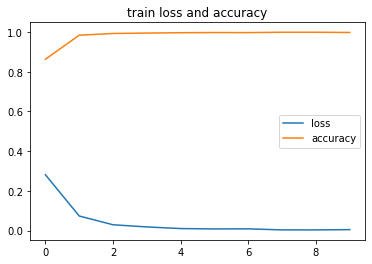

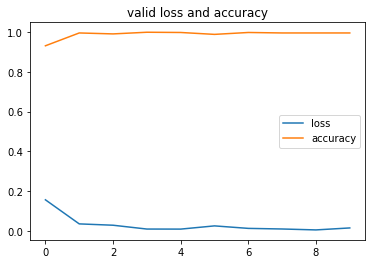

In [168]:
##pre trained ResNet을 학습하므로 lr을 매우 낮게 설정##

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fit(model, criterion, optimizer, 10, train_loader, test_loader)

